In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
folder = '/content/drive/MyDrive/chess_pieces'
image_size = (224, 224)
batch_size = 32
from keras.preprocessing.image import ImageDataGenerator

In [4]:
datagen = ImageDataGenerator(
        rotation_range=5,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        rescale=1./255,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(
    folder + '/train',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=True  
)

test_gen = test_datagen.flow_from_directory(
    folder + '/test',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=False 
)

Found 1182 images belonging to 13 classes.
Found 96 images belonging to 13 classes.


In [5]:
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions

model = VGG16(weights='imagenet')
model.summary()

553476096/553467096 [==============================] - 17s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model

In [7]:
epochs = 10
with tf.device('/device:GPU:0'):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
 
  # Freeze convolutional layers
  for layer in base_model.layers:
      layer.trainable = False

  # Establish new fully connected block
  x = base_model.output
  x = Flatten()(x)  # flatten from convolution tensor output  
  x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
  x = Dense(500, activation='relu')(x)
  predictions = Dense(13, activation='softmax')(x) # should match # of classes predicted

  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  history = model.fit(
      train_gen, 
      epochs=epochs,
      verbose = 1,
      validation_data=test_gen
      )
model.save_weights('model_VGG16.h5')

58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/10
37/37 [==============================] - 842s 22s/step - loss: 0.9383 - categorical_accuracy: 0.7775 - val_loss: 0.3109 - val_categorical_accuracy: 0.9062
Epoch 2/10
37/37 [==============================] - 18s 473ms/step - loss: 0.1570 - categorical_accuracy: 0.9594 - val_loss: 0.2522 - val_categorical_accuracy: 0.9167
Epoch 3/10
37/37 [==============================] - 18s 475ms/step - loss: 0.1041 - categorical_accuracy: 0.9729 - val_loss: 0.1847 - val_categorical_accuracy: 0.9583
Epoch 4/10
37/37 [==============================] - 18s 469ms/step - loss: 0.0565 - categorical_accuracy: 0.9839 - val_loss: 0.1230 - val_categorical_accuracy: 0.9479
Epoch 5/10
37/37 [==============================] - 17s 469ms/step - loss: 0.0338 - categorical_accuracy: 0.9932 - val_loss: 0.0552 - val_categorical_accuracy: 0.9896
Epoch 6/10
37/37 [==============================] - 17s 467ms/step - loss: 0.0238 - categorical_accur

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
model.save('piece_classifier')

INFO:tensorflow:Assets written to: piece_classifier/assets


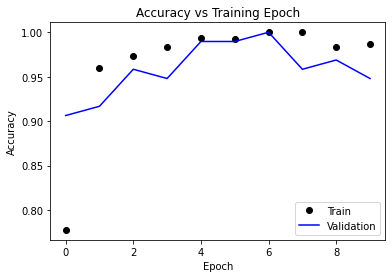

In [11]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(history.history['categorical_accuracy'], 'ko')
plt.plot(history.history['val_categorical_accuracy'], 'b')

plt.title('Accuracy vs Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

1.421875


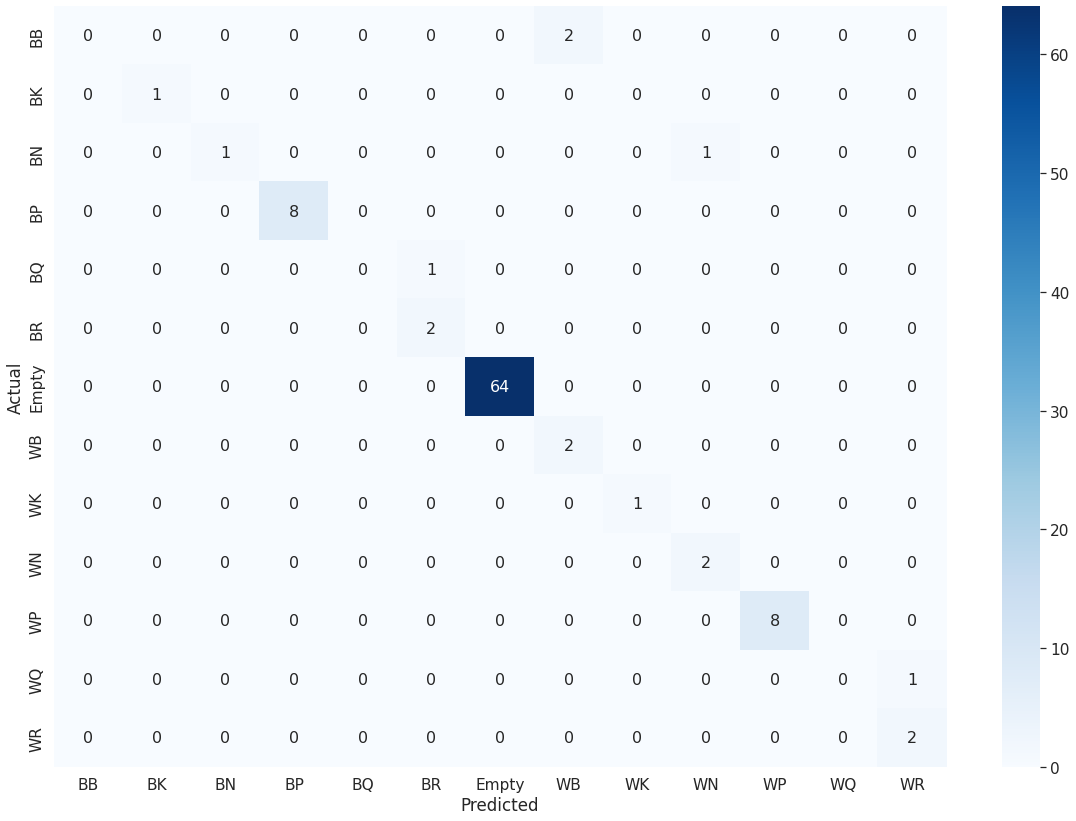

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['BB', 'BK', 'BN', 'BP', 'BQ', 'BR', 'Empty', 'WB', 'WK', 'WN', 'WP', 'WQ', 'WR']

test_gen.reset()
Y_pred = model.predict(test_gen)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)
print(sum(y_pred==classes)/64)


data = confusion_matrix(classes, y_pred)
df_cm = pd.DataFrame(data, columns=target_names, index = target_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,14))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size